[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
c:\Users\lexis\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - loss: 0.8151 - val_loss: 0.5234 - learning_rate: 0.0010
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - loss: 0.4662 - val_loss: 0.3336 - learning_rate: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - loss: 0.3146 - val_loss: 0.2316 - learning_rate: 0.0010
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - loss: 0.2210 - val_loss: 0.1632 - learning_rate: 0.0010
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.1576 - val_loss: 0.1166 - learning_rate: 0.0010
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - loss: 0.1150 - val_loss: 0.0853 - learning_rate: 0.0010
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - loss: 0.0871 - val_loss: 0.0643 - learning_rate: 0.0010
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.0682 - val_loss: 0.0499 - learning_rate: 0.0010
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - loss: 0.0538 - val_loss: 0.0413 - learning_rate: 0.0010


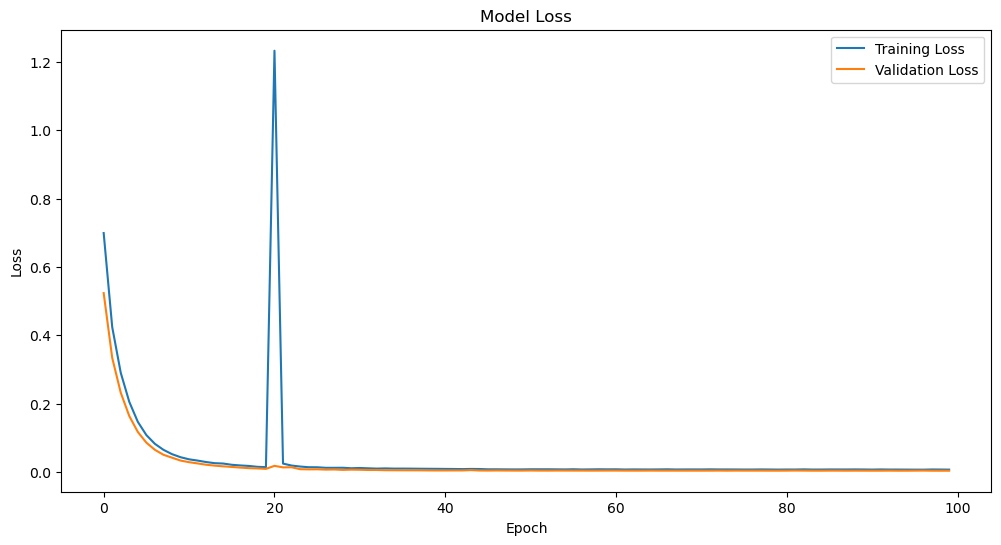

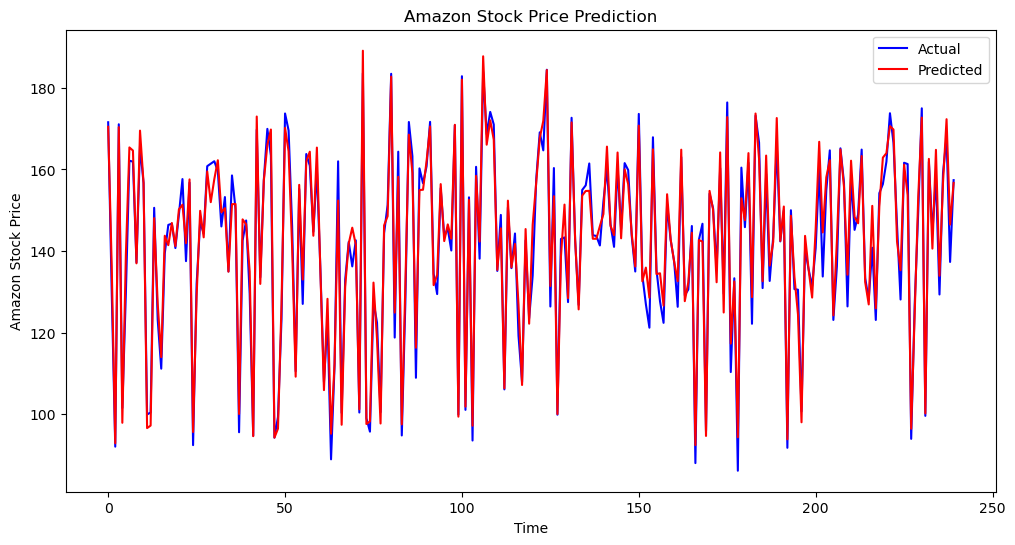

Shape of X_test_final: (1197, 60, 5)
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


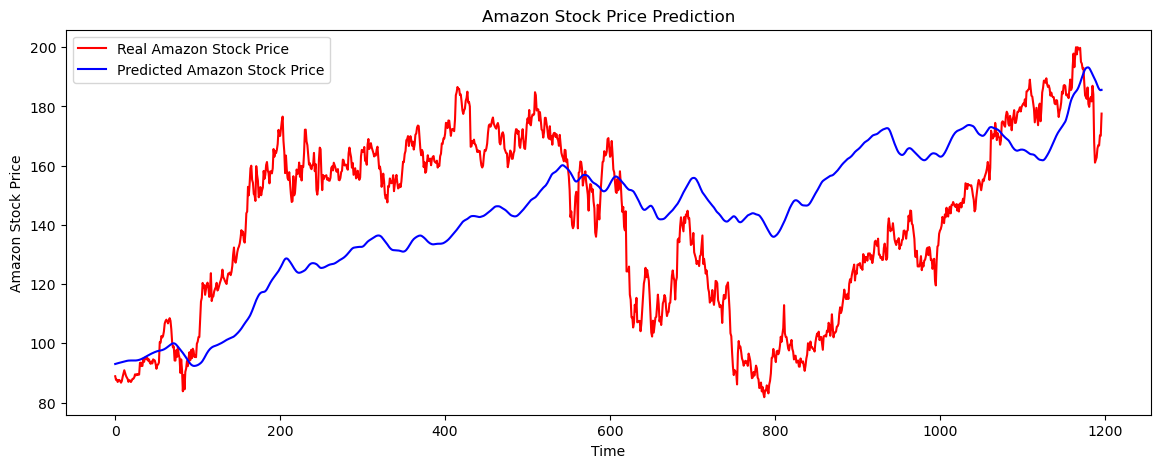

Final Mean Squared Error (MSE): 879.2683420891589
Final Root Mean Squared Error (RMSE): 29.652459292428997
Final Mean Absolute Error (MAE): 25.882608169899846
Final R-squared (R2) Score: 0.03677301774214281


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from datetime import datetime, timedelta

# Update only these variables
ticker = "AMZN"  # Change this to any stock ticker
company_name = "Amazon"  # Change this to any company name
training_tickers = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'ROKU']  # Training on these stocks

# Automatically set the start date to 5 years from today and end date to today
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=5*365)).strftime('%Y-%m-%d')

# Download and combine the data for all training tickers
combined_df = pd.DataFrame()

for training_ticker in training_tickers:
    df = yf.download(training_ticker, start=start_date, end=end_date)
    df = df[['Close']].rename(columns={'Close': training_ticker})
    if combined_df.empty:
        combined_df = df
    else:
        combined_df = combined_df.join(df, how='outer')

# Use the ticker's data for prediction and the combined data for training
target_df = combined_df[[ticker]].dropna()

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_combined_data = scaler.fit_transform(combined_df.fillna(0))  # Fill NaN with 0 before scaling
scaled_target_data = scaler.fit_transform(target_df.values.reshape(-1, 1))

# Create sequences from the combined data to train the model
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

sequence_length = 60  # Adjust as needed
X, y = create_sequences(scaled_combined_data, sequence_length)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Build the improved model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', recurrent_dropout=0.2),
    LSTM(100, return_sequences=True, activation='relu', recurrent_dropout=0.2),
    LSTM(100, activation='relu', recurrent_dropout=0.2),
    Dense(50, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1)
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Making predictions on the X_test data
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2) Score: {r2}")

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title(f'{company_name} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{company_name} Stock Price')
plt.legend()
plt.show()

# Extracting the 'Close' price for the ticker
stocktest = combined_df[[ticker]].dropna().values  # Ensure we get the correct column

# Scaling the input data
inputClosing_scaled = scaler.transform(stocktest)

# Preparing the test sequences using the same features as during training
X_test_final = []
for i in range(60, len(scaled_combined_data)):
    X_test_final.append(scaled_combined_data[i-60:i])

# Convert X_test_final to a NumPy array
X_test_final = np.array(X_test_final)

# Reshape X_test_final for LSTM: [samples, time steps, features]
X_test_final = np.reshape(X_test_final, (X_test_final.shape[0], X_test_final.shape[1], X_test_final.shape[2]))

# Check the shape to ensure it's correct
print("Shape of X_test_final:", X_test_final.shape)

# Making predictions on the actual stock test data
y_pred_final = model.predict(X_test_final)

# Inverse transform the predictions to original scale
amzn_predictions = scaler.inverse_transform(y_pred_final)  # Store final predictions in ticker_predictions variable

# Plotting the results
plt.figure(figsize=(14, 5))
plt.plot(stocktest[60:], color='red', label=f'Real {company_name} Stock Price')
plt.plot(amzn_predictions, color='blue', label=f'Predicted {company_name} Stock Price')
plt.title(f'{company_name} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{company_name} Stock Price')
plt.legend()
plt.show()

# Calculating metrics for the final predictions
mse_final = mean_squared_error(stocktest[60:], amzn_predictions)
rmse_final = np.sqrt(mse_final)
mae_final = mean_absolute_error(stocktest[60:], amzn_predictions)
r2_final = r2_score(stocktest[60:], amzn_predictions)

print(f"Final Mean Squared Error (MSE): {mse_final}")
print(f"Final Root Mean Squared Error (RMSE): {rmse_final}")
print(f"Final Mean Absolute Error (MAE): {mae_final}")
print(f"Final R-squared (R2) Score: {r2_final}")
